In [3]:
from posteriordb import PosteriorDatabase

import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from jax import random, vmap, jit
import jax.numpy as jnp
import jax

import numpyro
import numpyro.distributions as dist
import numpyro.infer as infer
from numpyro.infer.inspect import render_model
from numpyro.diagnostics import hpdi

from AMH import *
from evaluation import wasserstein_1d, wasserstein_dist11_p, wasserstein_sinkhorn_unbiased, max_sliced_wasserstein

# 1. Univariate distribution

In [4]:
mixing_dist = dist.Categorical(probs=jnp.array([1/3, 2/3]))
component_dist = dist.Normal(loc=jnp.array([-5, 5]), scale=jnp.array([1, 1]))
mixture = dist.MixtureSameFamily(mixing_dist, component_dist)

potential_fn = lambda x: -1 *mixture.log_prob(x)

In [5]:
kernel = AMH(potential_fn=potential_fn)

## 1.1. Sampling adaptive states

In [8]:
k1, k2 = random.split(random.PRNGKey(0))
s1 = sample_adapt_state(k1)
s2 = sample_neigbour(k2, s1, eps=0.01)

sample_dist1 = dist.MultivariateNormal(loc=s1.mean, covariance_matrix=jnp.exp(s1.log_step_size)*s1.covariance)
sample_dist2 = dist.MultivariateNormal(loc=s2.mean, covariance_matrix=jnp.exp(s2.log_step_size)*s2.covariance)

state_dist(s1, s2)

Array(0.01637393, dtype=float32)

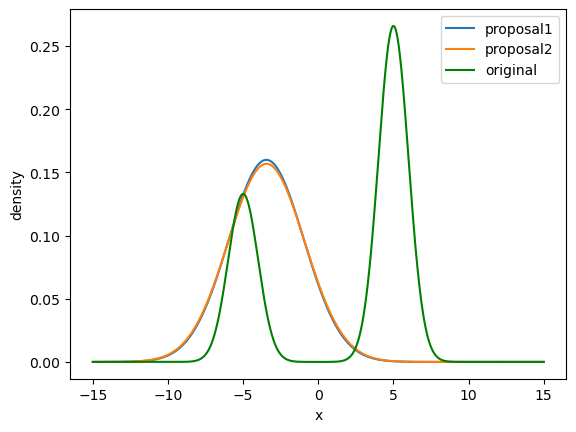

In [9]:
x_dist = jnp.arange(-15, 15, .002)
# plt.hist(mcmc.get_samples(), bins=50, density=True, label="samples")
plt.plot(x_dist, jnp.exp(vmap(sample_dist1.log_prob)(x_dist)), label="proposal1")
plt.plot(x_dist, jnp.exp(vmap(sample_dist2.log_prob)(x_dist)), label="proposal2")
plt.plot(x_dist, jnp.exp(mixture.log_prob(x_dist)), color="green", label="original")

plt.ylabel("density")
plt.xlabel("x")
plt.legend()

## 1.2. Sampling from $P(x, \cdot)$

In [10]:
%%time 

x = jnp.arange(-10, 10, 0.01)
N = 100

k1, k2 = random.split(random.PRNGKey(0))

P1x = sample_Px(k1, kernel, x, s1, N)
P2x = sample_Px(k2, kernel, x, s2, N)

CPU times: user 2.25 s, sys: 1.43 s, total: 3.68 s
Wall time: 1.94 s


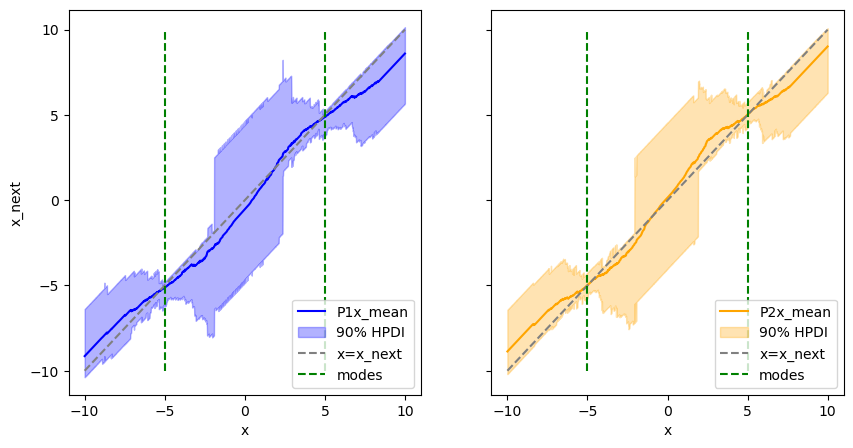

In [11]:
P1x_mean = P1x.mean(axis=0)
P1x_hdpi = hpdi(P1x, prob=0.9)
P2x_mean = P2x.mean(axis=0)
P2x_hdpi = hpdi(P2x, prob=0.9)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10,5))
ax1.plot(x, P1x_mean, color='blue', label="P1x_mean")
ax2.plot(x, P2x_mean, color='orange', label="P2x_mean")
ax1.fill_between(x, *P1x_hdpi, alpha=0.3, color="blue", label="90% HPDI")
ax2.fill_between(x, *P2x_hdpi, alpha=0.3, color="orange", label="90% HPDI")
ax1.plot(x, x, '--', color="gray", label="x=x_next")
ax2.plot(x, x, '--', color="gray", label="x=x_next")
ax1.vlines([-5, 5], -10, 10, linestyles='--', color="green", label="modes")
ax2.vlines([-5, 5], -10, 10, linestyles='--', color="green", label="modes")
ax1.set_ylabel("x_next")
ax1.set_xlabel("x")
ax2.set_xlabel("x")
ax1.legend(loc="lower right")
ax2.legend(loc="lower right")

## 1.3. Invariance Property

In [12]:
%%time

k1, k2, ks = random.split(random.PRNGKey(0), 3)
dist_samples = mixture.sample(ks, sample_shape=(1000,))

P1pi = sample_Px(k1, kernel, dist_samples, s1, n_samples=1000).flatten()
P2pi = sample_Px(k2, kernel, dist_samples, s2, n_samples=1000).flatten()

CPU times: user 2.96 s, sys: 6.94 s, total: 9.9 s
Wall time: 6.12 s


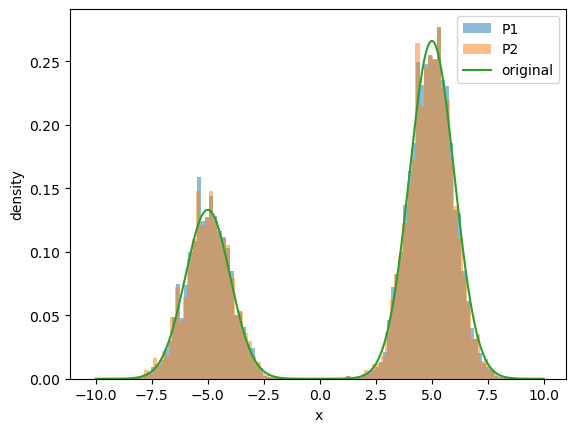

In [13]:
plt.hist(P1pi, bins=100, density=True, alpha=0.5, label="P1")
plt.hist(P2pi, bins=100, density=True, alpha=0.5, label="P2")
plt.plot(x, jnp.exp(mixture.log_prob(x)), label="original")
plt.xlabel("x")
plt.ylabel("density")
plt.legend()

## 1.4. Contraction Property

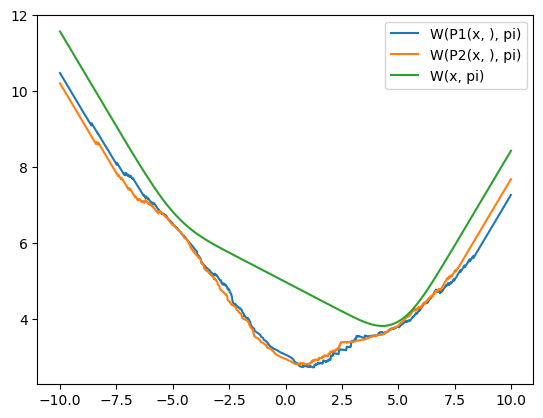

In [14]:
W_P1xpi = wasserstein_1d(dist_samples[None, :N], P1x.T)
W_P2xpi = wasserstein_1d(dist_samples[None, :N], P2x.T)
E_x = wasserstein_1d(dist_samples[None, :], x[:, None])

plt.plot(x, W_P1xpi, label="W(P1(x, ), pi)")
plt.plot(x, W_P2xpi, label="W(P2(x, ), pi)")
plt.plot(x, E_x, label="W(x, pi)")
plt.legend()

# Lipschitz Property

In [15]:
def sample_lipschitz_func(rng_key, domain=(-10, 10), step=0.1):
    """
    Generates a random 1-Lipschitz finction with given domain and grid size
    """
    points = jnp.arange(*domain, step)
    N, = points.shape

    u = dist.Uniform(-1, 1).sample(rng_key, sample_shape=(N,))
    u -= u.mean()
    u /= jnp.max(jnp.abs(u))
    
    values = jnp.tri(N,N) @ u * step
    
    return jax.scipy.interpolate.RegularGridInterpolator((points,), values, fill_value=0)

In [16]:
func = sample_lipschitz_func(random.PRNGKey(0), domain=(-10, 10), step=0.1)

P1fx = vmap(func)(P1x).mean(axis=0)
P2fx = vmap(func)(P2x).mean(axis=0)

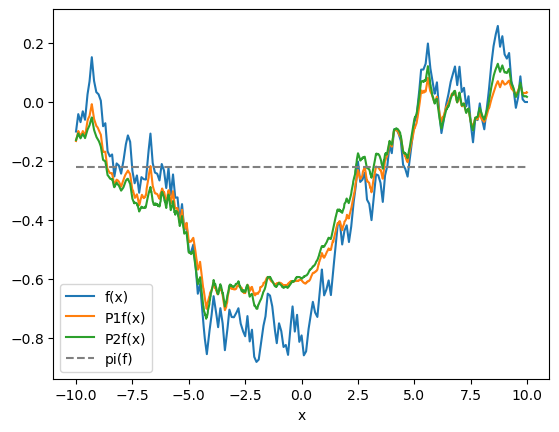

In [17]:
plt.plot(x, func(x), label="f(x)")
plt.plot(x, P1fx, label="P1f(x)")
plt.plot(x, P2fx, label="P2f(x)")
# plt.plot(x, jnp.abs(P1fx-P2fx), label="diff")
plt.hlines(func(dist_samples).mean(), x.min(), x.max(), linestyles="--", color="gray", label="pi(f)")
plt.xlabel("x")
plt.legend()

In [18]:
diff = P1fx - P2fx

diff_norm = jnp.abs(jnp.diff(diff)/jnp.diff(x)).max()
diff_norm

Array(1.3648853, dtype=float32)

In [81]:
def compute_lipschitz(rng_key, kernel, eps=0.001, domain=(-10, 10), step=0.01):

    x = jnp.arange(*domain, step)
    key_func, rng_key = random.split(rng_key)
    func = sample_lipschitz_func(key_func, domain, 10*step)
    
    key_state1, key_state2, key_kernel1, key_kernel2 = random.split(rng_key, 4)
    
    s1 = sample_adapt_state(key_state1)
    s2 = sample_neigbour(key_state2, s1, eps)
    
    P1x = sample_Px(key_kernel1, kernel, x, s1, n_samples=100)
    P2x = sample_Px(key_kernel2, kernel, x, s2, n_samples=100)
    
    P1fx = vmap(func)(P1x).mean(axis=0)
    P2fx = vmap(func)(P2x).mean(axis=0)
    
    diff = P1fx - P2fx

    diff_norm = jnp.abs(jnp.diff(diff)/jnp.diff(x)).max()

    return diff_norm, state_dist(s1, s2)

In [84]:
%%time

rng_key = random.split(random.PRNGKey(0), 10)

diff_norm, states_dist = vmap(lambda key: compute_lipschitz(key, kernel))(rng_key)

CPU times: user 14.9 s, sys: 1min 32s, total: 1min 46s
Wall time: 5min 32s


[]

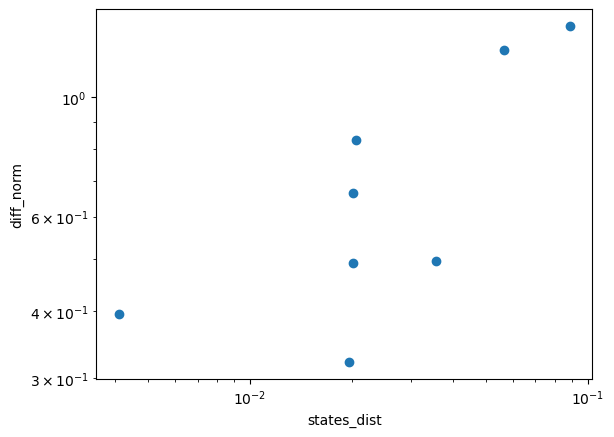

In [88]:
plt.scatter(states_dist, diff_norm)
plt.ylabel("diff_norm")
plt.xlabel("states_dist")
plt.semilogx()
plt.semilogy()

In [ ]:
# %%time

# N = 100
# rng_key = random.split(random.PRNGKey(0), N)

# diff_norm, states_dist = vmap(compute_lipschitz)(rng_key)

# d = {"rng_key": rng_key, "diff_norm": diff_norm, "states_dist": states_dist}
# with open("lipschitz.pkl", "wb") as f:
#     pickle.dump(d, f)

In [90]:
with open("lipschitz.pkl", "rb") as f:
    d = pickle.load(f)

L = jnp.max(d["diff_norm"] / d["states_dist"])
L

Array(45.881367, dtype=float32)

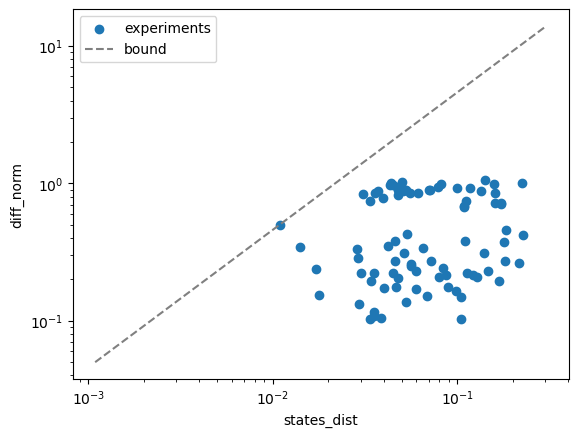

In [110]:
plt.scatter(d["states_dist"], d["diff_norm"], label="experiments")

dists = jnp.logspace(jnp.log10(d["states_dist"].min()) -1, jnp.log10(d["states_dist"].max()))
plt.plot(dists, L*dists, "--", color="gray", label="bound")

plt.ylabel("diff_norm")
plt.xlabel("states_dist")
plt.semilogx()
plt.semilogy()
plt.legend()

# 2. Posteriordb

In [ ]:
pdb_path = "../../posteriordb/posterior_database"
my_pdb = PosteriorDatabase(pdb_path)

In [ ]:
posterior = my_pdb.posterior("kidiq-kidscore_momhsiq")

p_model = posterior.model
p_data = posterior.data

In [ ]:
data = {key: jnp.array(val) for key, val in posterior.data.values().items() if type(val) is list}
data_rest = {key: val for key, val in posterior.data.values().items() if type(val) is not list}

In [ ]:
reference_draws_df = pd.concat([
    pd.DataFrame(chain_draw).assign(chain_id=i)
    for i, chain_draw in enumerate(posterior.reference_draws())
])
reference_draws_df.drop(columns=["chain_id"], inplace=True)

In [ ]:
def model(mom_iq, mom_hs, kid_score=None):

    # Priors
    beta = numpyro.sample("beta", dist.ImproperUniform(dist.constraints.real_vector, (), event_shape=(3,)))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(2.5))

    
    # Linear model
    ones = jnp.ones_like(mom_hs)
    X = jnp.stack([ones, mom_hs, mom_iq], axis=1)
    mu = jnp.matmul(X, beta)
    # mu = beta[0] + beta[1] * mom_hs + beta[2] * mom_iq

    # Observed variable
    numpyro.sample("kid_score_obs", dist.Normal(mu, sigma), obs=kid_score)

render_model(model, model_kwargs=data, render_distributions=True)

In [ ]:
kernel = AMH(model)

In [ ]:
rng_key = random.PRNGKey(1)

In [ ]:
jax.scipy.linalg.eigh(C)

In [ ]:
jax.scipy.linalg.eigh(C1)